# Homework 4

In [1]:
import numpy as np
import cloudpickle

import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import json

from os import makedirs
makedirs('hw4_models', exist_ok=True)

torch.manual_seed(0)

# Use a GPU if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
device

device(type='mps')

## Problem 1

> Choose a generative ML/AI method from among variational autoencoder, generative adversarial network, diffusion, or normalizing flow. Train the method on the APOGEE spectral data set you used in PS3. Generate 1024 new spectra using your generator. Make some plots comparing real spectra (from the test set, maybe) and generated spectra. Do your generated spectra look believable?

First, let's load the data. In `hw3_data.ipynb`, I already did all the preprocessing and saved the results, so let's load it and convert the data into torch Tensors.

In [2]:
# load cached data
with open('hw3_data/train_labels.pkl', 'rb') as f:
    train_labels = cloudpickle.load(f)
with open('hw3_data/val_labels.pkl', 'rb') as f:
    valid_labels = cloudpickle.load(f)
with open('hw3_data/test_labels.pkl', 'rb') as f:
    test_labels = cloudpickle.load(f)

train_features = np.load('hw3_data/train_features.npy')
valid_features = np.load('hw3_data/val_features.npy')
test_features = np.load('hw3_data/test_features.npy')


# convert to torch tensors
def feat_to_tensor(features):
    return torch.tensor(features).to(torch.float32).to(device)

def labels_to_tensor(labels):
    return torch.tensor(labels['LOGG'].astype('=f4')).to(torch.float32).to(device)

X_tr, X_va, X_te = map(feat_to_tensor,   [train_features, valid_features, test_features])
Y_tr, Y_va, Y_te = map(labels_to_tensor, [train_labels,   valid_labels,   test_labels])

m = X_tr.shape[1]
print(m)

8575


I want to make and train a VAE. For simplicity, I'm going to take my final output to have zero variance, so we'll just take the output of the decoder as the prediction itself and not a distribution to be sampled from. I'm also going to take my latent variables to be independent Gaussians ("assumption of mean field variational inference"), so the encoder only needs to output means and standard deviations.

In [3]:
from hw4_net1 import VAE

model = VAE().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
sched = torch.optim.lr_scheduler.StepLR(optim, 200, gamma=0.8)

history = []

name = "net_1"

In [4]:
# check if model already exists;
# if so, skip training

try:
    state_dict = torch.load(f"hw4_models/{name}.pt", map_location=device)
    model.load_state_dict(state_dict)
    
    with open(f"hw4_models/{name}_history.json", "r") as f:
        history = json.load(f)
        
    print("Loaded", name, "from prior training.")
        
except Exception as err:
    print("Loading failed with exception:")
    print(str(err))
    
    print("Training from scratch.")
    
    model.train()

    for i in tqdm(range(100)):
        to_log = {
            'epoch': i,
            'lr': optim.param_groups[0]['lr'],
            'loss_tr': 0,
            'loss_va': 0,
        }
        optim.zero_grad()
        X_hat, loss = model(X_tr)
        to_log['loss_tr'] = loss.detach().cpu().item()

        if torch.isnan(loss):
            raise RuntimeError('nan')

        loss.backward()
        optim.step()
        sched.step()

        with torch.no_grad():
            _, loss = model(X_va)
            to_log['loss_va'] = loss.detach().cpu().item()

        history.append(to_log)
        
    torch.save(model.state_dict(), f"hw4_models/{name}.pt")

    with open(f"hw4_models/{name}_history.json", "w") as f:
        json.dump(history, f)

Loaded net_1 from prior training.


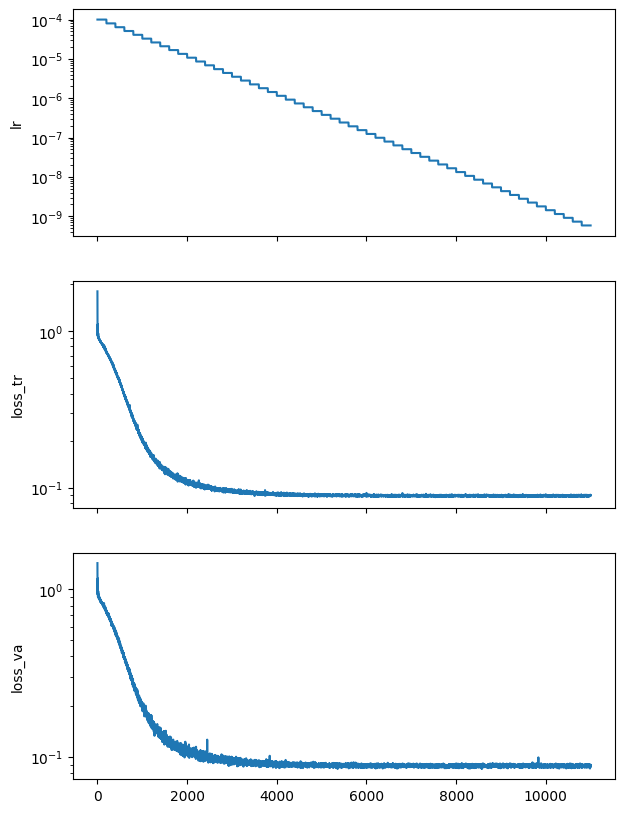

In [5]:
def plot_history(h):
    flipped = {k: [log[k] for log in h] for k in h[0].keys()}
    
    fig, axs = plt.subplots( len(flipped) - 1, 1, sharex=True, figsize=(7, 10) )
    
    i = 0
    for k in flipped.keys():
        if k == 'epoch':
            continue
            
        ax = axs[i]
        ax.plot(flipped['epoch'], flipped[k])
        ax.set_ylabel(k)
        ax.set_yscale('log')
        
        i += 1
        
    plt.show()
        
plot_history(history)

I probably didn't need to leave it running that long, but it looks super well converged!

Let's make some samples.

In [6]:
def sample(model, n):
    with torch.no_grad():
        ell = model.encoder.cnn[-1].out_features // 2
        z = torch.randn((n, ell), device=device)
        x_hat = model.decoder(z)
    return x_hat

model.eval()
X_hat = sample(model, 10)

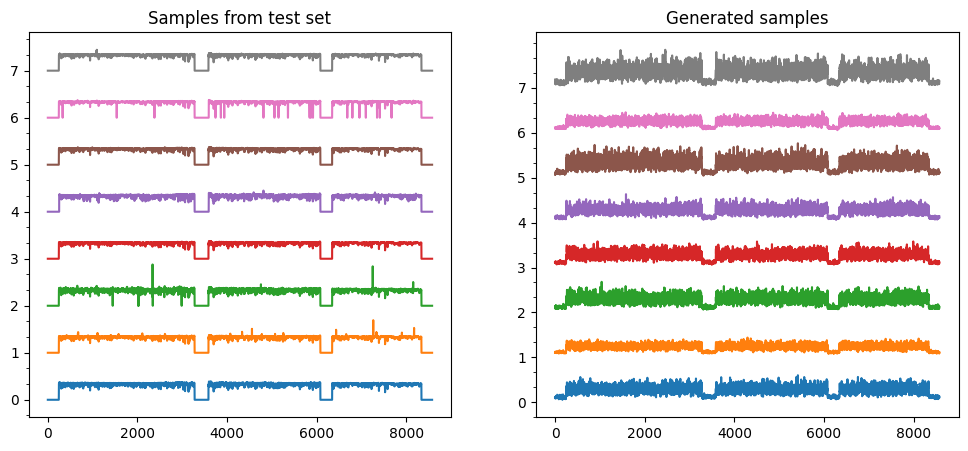

In [7]:
from matplotlib.ticker import AutoMinorLocator

n_spectra = 8
spacing = 3

rng = np.random.default_rng()
idx = rng.permutation(len(X_te))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i in range(n_spectra):
    axs[0].plot(X_te.cpu().numpy()[idx[i]] + spacing * i)
    axs[1].plot(X_hat.cpu().numpy()[i] + spacing * i)

for ax in axs.flat:
    ax.set_yticks(np.arange(n_spectra) * spacing)
    ax.set_yticklabels([f"{i}" for i in range(n_spectra)])
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=spacing))
    
axs[0].set_title("Samples from test set")
axs[1].set_title("Generated samples")

plt.show()

Our spectra are not super believable. They kinda look like really noisy data samples, but they're noisy even in places that they shouldn't be (like the gaps, which should be filled _zero_).

We can also 'bias' our model to generate things that look _like_ an individual sample by first giving it a sample as inspiration. Does this produce better samples?

In [8]:
model.eval()

def sample_with_inspiration(model, x, n_samples=1):
    with torch.no_grad():
        mu, sigma = model.encoder(x)
        eps = torch.randn((mu.shape[0], n_samples, mu.shape[-1]), device=mu.device)
        z = mu.unsqueeze(1) + sigma.unsqueeze(1) * eps

        # flatten all samples along batch dimension and pass to decoder
        z = torch.reshape(z, (mu.shape[0] * n_samples, mu.shape[-1]))
        x_hat = model.decoder(z)

        # unflatten back out
        x_hat = torch.reshape(x_hat, (x.shape[0], n_samples, x.shape[-1]))
        return x_hat


# just the first four
X_hat = sample_with_inspiration(model, X_te[:4], n_samples=4)

/Users/connor/Documents/nyu/2023-24S/ml4phys/hw/hw4_net1.py:8: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  x[mask] = torch.log(1 + torch.exp(z[mask])) / beta


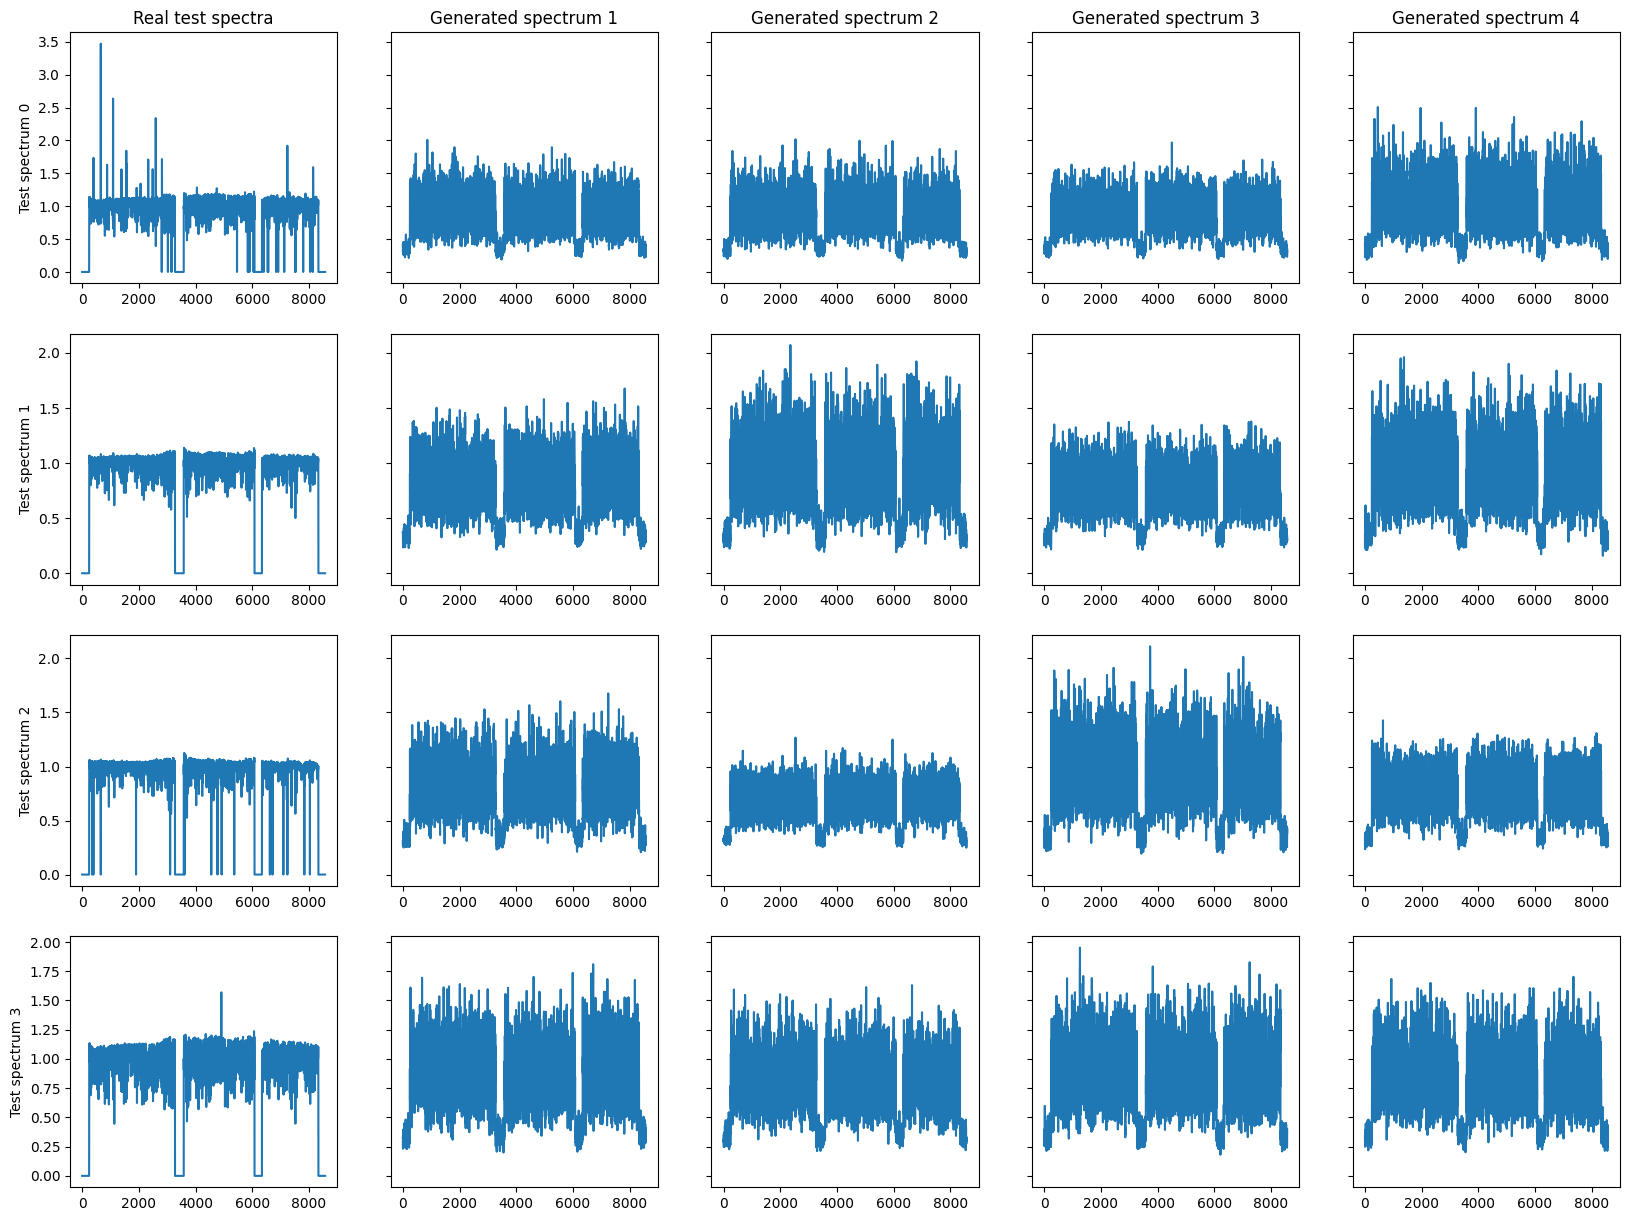

In [9]:
fig, axs = plt.subplots(4, 5, figsize=(20, 15), sharey='row')

for row in range(4):
    
    axs[row, 0].plot(X_te.cpu().numpy()[row])
    
    for i in range(4):
        axs[row, i + 1].plot(X_hat.cpu().numpy()[row,i])
        
    axs[row, 0].set_ylabel(f"Test spectrum {row}")
    
axs[0, 0].set_title("Real test spectra")
axs[0, 1].set_title("Generated spectrum 1")
axs[0, 2].set_title("Generated spectrum 2")
axs[0, 3].set_title("Generated spectrum 3")
axs[0, 4].set_title("Generated spectrum 4")
    
    
plt.show()

Nah, these are just as bad. Let's generate 1024 (without "inspiration").

In [10]:
model.eval()
X_hat = sample(model, 1024)

## Problem 2

> Now ask: Is the generator just memorizing your training data? Ask this question by comparing the distribution of nearest-neighbor distances (generated data to training data) to the same for the test data (test data to training data). Show some histograms and conclude something.

It is definitely not memorizing the training data!

But I will try to show that quantitatively instead of just gesturing at the plots.

In [11]:
def nn_dist(x1, x2):
    """for each point in x1, computes the distance to the nearest point in x2"""
    from sklearn.neighbors import NearestNeighbors
    
    nngb = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x2)
    dist, _ = nngb.kneighbors(x1, return_distance=True)
    col = 1 if (dist[:, 0] == 0).all() else 0
    return dist[:, col]

gen_dist = nn_dist(X_hat.cpu().numpy(), X_tr.cpu().numpy())
test_dist = nn_dist(X_te.cpu().numpy(), X_tr.cpu().numpy())

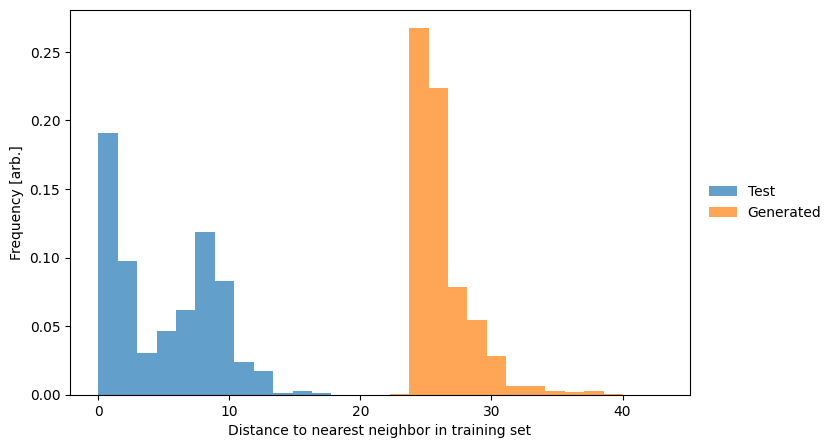

In [12]:
plt.figure(figsize=(8, 5))
kw = dict(alpha=0.7, density=True, bins=np.linspace(0, 43, 30))
plt.hist(test_dist, label="Test", **kw)
plt.hist(gen_dist, label="Generated", **kw)
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.xlabel("Distance to nearest neighbor in training set")
plt.ylabel("Frequency [arb.]")
plt.show()

Not even a little bit the same. I'm sure I could get better spectra eventually if I keep playing with the model and loss function, but for now this is all I've got.

P.S. I _did_ try to just beef up the model a little by adding another convolutional layer and doubling up all the convolutional layers in the decoder with `ConvTranspose` layers, but the model learned to predict only the mean value for all pixels. Not sure how that happened, but it was consistent across different random seeds and hyperparameters. You could even take snapshots as it trained and see how the generated spectra started as totally random noise and slowly converged on a single mean value.

## Problem 3

> Agree, as a whole class (use the Discord), on which student’s regression code from PS3 did the best at predicting labels on held-out data. Share that regression code across the class, and insert your fake generated spectra from problem 1 into that regression code. Make comparison plots between the labels you get for the test data from PS3 with that regression method, and the labels you get for your generated data.

Since no one has posted their results in the Discord, I'm just going to use my own best model.

In [43]:
# copy-pasted from Homework 3
def make_cnn(channel_sizes, mlp_sizes, activation=nn.ReLU, kernel_size=3):
    if len(channel_sizes) < 2:
        raise ValueError('channel_sizes must be at least length 2 (in, [hiddens...,] out)')
    
    layers = []
    
    # add the conv layers, interleaved with activation
    kw = dict(padding='same', padding_mode='circular')
    for i in range(len(channel_sizes) - 1):
        c1 = channel_sizes[i]
        c2 = channel_sizes[i + 1]
        layers.append(nn.Conv1d(c1, c2, kernel_size, **kw))
        layers.append(activation())
    
    # add a reshape to flatten the multi-channeled features
    layers.append(nn.Flatten())
    
    # add the MLP layers, interleaved with activation
    fc_sizes = [ channel_sizes[-1] * m ] + mlp_sizes + [1]
    for i in range(len(fc_sizes) - 1):
        m1 = fc_sizes[i]
        m2 = fc_sizes[i + 1]
        layers.append(nn.Linear(m1, m2))
        if i != len(fc_sizes) - 2:
            layers.append(activation())
    
    return nn.Sequential(*layers)

hw3net = make_cnn([1, 4, 4, 4, 4], [], kernel_size=3).to(device)
state_dict = torch.load('hw3_models/conv_03.pt', map_location=device)
hw3net.load_state_dict(state_dict)

<All keys matched successfully>

In [44]:
pred_test = hw3net(X_te.unsqueeze(1)).squeeze().detach().cpu().numpy()
pred_gen = hw3net(X_hat.unsqueeze(1)).squeeze().detach().cpu().numpy()

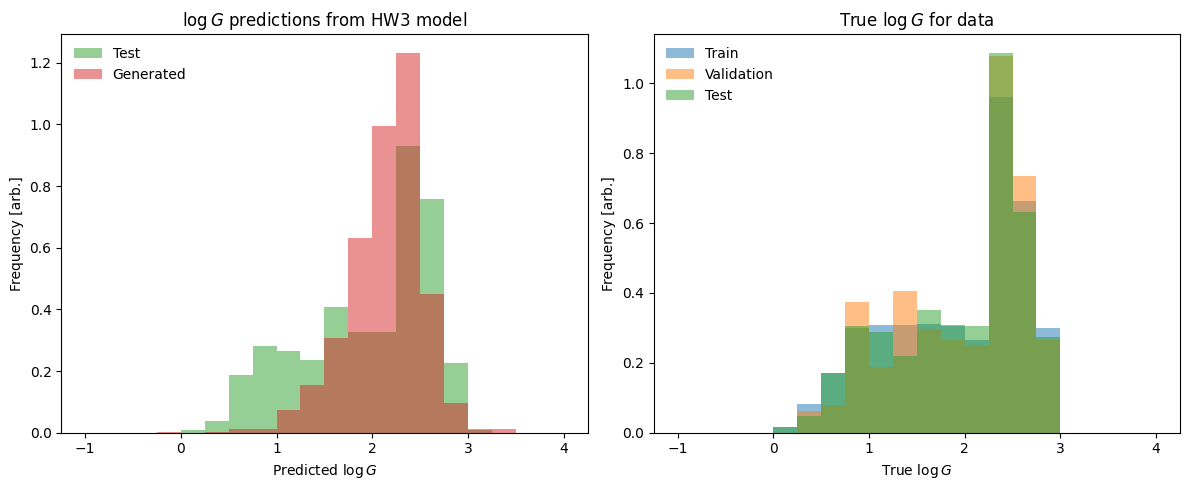

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

kw = dict(alpha=0.5, density=True, bins=np.linspace(-1, 4, 21))
axs[0].hist(pred_test, label='Test', color='C2', **kw)
axs[0].hist(pred_gen, label='Generated', color='C3', **kw)
axs[0].legend(frameon=False, loc='upper left')
axs[0].set_xlabel('Predicted $\\log G$')
axs[0].set_ylabel('Frequency [arb.]')
axs[0].set_title('$\\log G$ predictions from HW3 model')

axs[1].hist(Y_tr.squeeze().detach().cpu().numpy(), label="Train", **kw)
axs[1].hist(Y_va.squeeze().detach().cpu().numpy(), label="Validation", **kw)
axs[1].hist(Y_te.squeeze().detach().cpu().numpy(), label="Test", **kw)
axs[1].legend(frameon=False, loc='upper left')
axs[1].set_xlabel('True $\\log G$')
axs[1].set_ylabel('Frequency [arb.]')
axs[1].set_title("True $\\log G$ for data")

fig.tight_layout()
plt.show()

The generated data produce a nearly perfect Gaussian distribution with a mean of around 1.8, while the test data have a more interesting distribution of predicted labels. The 'interesting' distribution of predicted labels also seems to agree quite well with the true label distributions for all three of our datasets.

I think it's curious that the distribution of this _function_ of our spectra is so well-described by a Gaussian with a mean near that of the true distribution.

## Problem 4

> Write a title and a 300-ish word abstract for your final project. Do this in a LaTeX file or Google Doc and either send Hogg the PDF or else point Hogg to an Overleaf or Google Doc or equivalent. For your abstract, use the form “context, aims, methods, results” where “results” will obviously be vague at this point (you don’t have results yet). If you have questions, discuss on Discord.

Will do this and send separately!